# Hand Gesture Classification using EMG

**EMG Pattern Classification**

For recording patterns, the author used a MYO Thalmic bracelet worn on a user’s forearm, and a PC with a Bluetooth receiver. The bracelet is equipped with **eight sensors** equally spaced around the forearm that simultaneously acquire myographic signals. The signals are sent through a Bluetooth interface to a PC. 


    Author: Debanjan Saha
    College: Northeastern University
    Group: Project Group 7
    Batch: Wednesday
    Course: IE 7300
    Professor: Ramin M.

This dataset contains raw EMG data for **36** subjects while they performed series of static hand gestures.The subject performs two series, each of which consists of **six (seven) basic gestures**. Each gesture was **performed for 3 seconds** with a **pause** of **3 seconds between gestures**.

Relevant Paper:
Lobov S., Krilova N., Kastalskiy I., Kazantsev V., Makarov V.A. Latent Factors Limiting the Performance of sEMG-Interfaces. Sensors. 2018;18(4):1122. doi: 10.3390/s18041122



In [1]:
!pip install nolds
# !pip install pyeeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import librosa
import nolds
# import pyeeg
sns.set_style('darkgrid')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 500)

In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from scipy import stats

In [4]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master'
!ls -lrt

/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master
total 146
-rw------- 1 root root 1453 Dec  7  2018 README.txt
drwx------ 2 root root 4096 Mar 23 20:40 10
drwx------ 2 root root 4096 Mar 23 20:40 09
drwx------ 2 root root 4096 Mar 23 20:40 08
drwx------ 2 root root 4096 Mar 23 20:40 07
drwx------ 2 root root 4096 Mar 23 20:40 06
drwx------ 2 root root 4096 Mar 23 20:40 05
drwx------ 2 root root 4096 Mar 23 20:40 04
drwx------ 2 root root 4096 Mar 23 20:40 03
drwx------ 2 root root 4096 Mar 23 20:40 02
drwx------ 2 root root 4096 Mar 23 20:40 01
drwx------ 2 root root 4096 Mar 23 20:40 20
drwx------ 2 root root 4096 Mar 23 20:40 19
drwx------ 2 root root 4096 Mar 23 20:40 18
drwx------ 2 root root 4096 Mar 23 20:40 17
drwx------ 2 root root 4096 Mar 23 20:40 16
drwx------ 2 root root 4096 Mar 23 20:40 15
drwx------ 2 root root 4096 Mar 23 20:40 14
drwx------ 2 root root 4096 Mar 23 20:40 13
drwx------ 2 root root 4096 Mar 23 20:40 12
drwx------ 2 

## Read Data

In [6]:
# List out all the available files in the project's environment
files_path = set()
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/'):
    for filename in filenames:
        f_path = os.path.join(dirname, filename)
        files_path.add(f_path)

In [7]:
files_path.discard('/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/README.txt')
files_path

{'/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/01/1_raw_data_13-12_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/01/2_raw_data_13-13_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/02/1_raw_data_14-19_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/02/2_raw_data_14-21_22.03.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/03/1_raw_data_09-32_11.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/03/2_raw_data_09-34_11.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/04/1_raw_data_18-02_24.04.16.txt',
 '/content/drive/MyDrive/Northeastern/Projects/IE7300 Project/EMG_data_for_gestures-master/04/2_raw_data_18-03_24.04.1

In [24]:
all_data = pd.DataFrame()
for id, file in enumerate(tqdm(sorted(files_path))):
    # if id == 1: 
    sub = int(file.split('/')[-2])
    data = pd.read_csv(file, sep='\t')
    subject_id = np.ones([len(data),1], dtype=np.int16)*sub
    print('\tSubject Id: \t', sub, '\tShape: ', subject_id.shape)
    # Add the subject into the data
    data['subject_id'] = subject_id
    all_data = pd.concat([all_data, data], axis=0, ignore_index=True, copy=True)
print('Total Records: ', all_data.shape)

  3%|▎         | 2/72 [00:00<00:05, 13.74it/s]

	Subject Id: 	 1 	Shape:  (63196, 1)
	Subject Id: 	 1 	Shape:  (57974, 1)
	Subject Id: 	 2 	Shape:  (72322, 1)


  8%|▊         | 6/72 [00:00<00:05, 12.48it/s]

	Subject Id: 	 2 	Shape:  (64104, 1)
	Subject Id: 	 3 	Shape:  (56568, 1)
	Subject Id: 	 3 	Shape:  (49217, 1)


 11%|█         | 8/72 [00:00<00:05, 12.59it/s]

	Subject Id: 	 4 	Shape:  (59107, 1)
	Subject Id: 	 4 	Shape:  (55091, 1)
	Subject Id: 	 5 	Shape:  (57118, 1)


 17%|█▋        | 12/72 [00:00<00:04, 12.74it/s]

	Subject Id: 	 5 	Shape:  (50130, 1)
	Subject Id: 	 6 	Shape:  (51078, 1)
	Subject Id: 	 6 	Shape:  (48541, 1)


 19%|█▉        | 14/72 [00:01<00:05, 11.44it/s]

	Subject Id: 	 7 	Shape:  (68697, 1)
	Subject Id: 	 7 	Shape:  (63943, 1)
	Subject Id: 	 8 	Shape:  (60280, 1)


 22%|██▏       | 16/72 [00:01<00:05, 10.59it/s]

	Subject Id: 	 8 	Shape:  (57668, 1)
	Subject Id: 	 9 	Shape:  (62770, 1)


 25%|██▌       | 18/72 [00:01<00:05, 10.15it/s]

	Subject Id: 	 9 	Shape:  (64877, 1)
	Subject Id: 	 10 	Shape:  (61641, 1)


 29%|██▉       | 21/72 [00:01<00:05,  9.19it/s]

	Subject Id: 	 10 	Shape:  (61448, 1)
	Subject Id: 	 11 	Shape:  (74681, 1)


 32%|███▏      | 23/72 [00:02<00:05,  8.76it/s]

	Subject Id: 	 11 	Shape:  (72645, 1)
	Subject Id: 	 12 	Shape:  (65920, 1)


 35%|███▍      | 25/72 [00:02<00:05,  8.44it/s]

	Subject Id: 	 12 	Shape:  (62631, 1)
	Subject Id: 	 13 	Shape:  (75676, 1)


 38%|███▊      | 27/72 [00:02<00:05,  8.37it/s]

	Subject Id: 	 13 	Shape:  (77564, 1)
	Subject Id: 	 14 	Shape:  (52821, 1)


 40%|████      | 29/72 [00:02<00:04,  8.81it/s]

	Subject Id: 	 14 	Shape:  (48182, 1)
	Subject Id: 	 15 	Shape:  (53553, 1)


 43%|████▎     | 31/72 [00:03<00:04,  8.83it/s]

	Subject Id: 	 15 	Shape:  (51843, 1)
	Subject Id: 	 16 	Shape:  (55489, 1)


 46%|████▌     | 33/72 [00:03<00:04,  8.34it/s]

	Subject Id: 	 16 	Shape:  (50012, 1)
	Subject Id: 	 17 	Shape:  (65227, 1)


 49%|████▊     | 35/72 [00:03<00:04,  7.79it/s]

	Subject Id: 	 17 	Shape:  (66858, 1)
	Subject Id: 	 18 	Shape:  (62354, 1)


 51%|█████▏    | 37/72 [00:03<00:04,  7.61it/s]

	Subject Id: 	 18 	Shape:  (66958, 1)
	Subject Id: 	 19 	Shape:  (58818, 1)


 54%|█████▍    | 39/72 [00:04<00:04,  7.55it/s]

	Subject Id: 	 19 	Shape:  (51088, 1)
	Subject Id: 	 20 	Shape:  (65349, 1)


 57%|█████▋    | 41/72 [00:04<00:04,  7.39it/s]

	Subject Id: 	 20 	Shape:  (62504, 1)
	Subject Id: 	 21 	Shape:  (62365, 1)


 60%|█████▉    | 43/72 [00:04<00:03,  7.44it/s]

	Subject Id: 	 21 	Shape:  (56882, 1)
	Subject Id: 	 22 	Shape:  (61788, 1)


 61%|██████    | 44/72 [00:04<00:03,  7.40it/s]

	Subject Id: 	 22 	Shape:  (57841, 1)
	Subject Id: 	 23 	Shape:  (60135, 1)


 64%|██████▍   | 46/72 [00:05<00:03,  7.15it/s]

	Subject Id: 	 23 	Shape:  (55484, 1)
	Subject Id: 	 24 	Shape:  (61968, 1)


 67%|██████▋   | 48/72 [00:05<00:03,  6.75it/s]

	Subject Id: 	 24 	Shape:  (54972, 1)
	Subject Id: 	 25 	Shape:  (62681, 1)


 69%|██████▉   | 50/72 [00:05<00:03,  6.56it/s]

	Subject Id: 	 25 	Shape:  (54066, 1)
	Subject Id: 	 26 	Shape:  (56151, 1)


 72%|███████▏  | 52/72 [00:06<00:03,  6.21it/s]

	Subject Id: 	 26 	Shape:  (50003, 1)
	Subject Id: 	 27 	Shape:  (56688, 1)


 75%|███████▌  | 54/72 [00:06<00:03,  5.86it/s]

	Subject Id: 	 27 	Shape:  (50111, 1)
	Subject Id: 	 28 	Shape:  (50513, 1)


 78%|███████▊  | 56/72 [00:06<00:02,  6.04it/s]

	Subject Id: 	 28 	Shape:  (47253, 1)
	Subject Id: 	 29 	Shape:  (53904, 1)


 81%|████████  | 58/72 [00:07<00:02,  5.89it/s]

	Subject Id: 	 29 	Shape:  (52083, 1)


 82%|████████▏ | 59/72 [00:07<00:02,  5.60it/s]

	Subject Id: 	 30 	Shape:  (77878, 1)
	Subject Id: 	 30 	Shape:  (70683, 1)


 85%|████████▍ | 61/72 [00:07<00:02,  5.38it/s]

	Subject Id: 	 31 	Shape:  (44927, 1)
	Subject Id: 	 31 	Shape:  (46096, 1)


 88%|████████▊ | 63/72 [00:08<00:01,  5.33it/s]

	Subject Id: 	 32 	Shape:  (62719, 1)


 89%|████████▉ | 64/72 [00:08<00:01,  5.24it/s]

	Subject Id: 	 32 	Shape:  (60211, 1)
	Subject Id: 	 33 	Shape:  (59017, 1)


 92%|█████████▏| 66/72 [00:08<00:01,  5.11it/s]

	Subject Id: 	 33 	Shape:  (53088, 1)


 93%|█████████▎| 67/72 [00:08<00:01,  4.63it/s]

	Subject Id: 	 34 	Shape:  (79765, 1)


 94%|█████████▍| 68/72 [00:09<00:00,  4.55it/s]

	Subject Id: 	 34 	Shape:  (51438, 1)


 96%|█████████▌| 69/72 [00:09<00:00,  4.48it/s]

	Subject Id: 	 35 	Shape:  (50417, 1)


 97%|█████████▋| 70/72 [00:09<00:00,  4.39it/s]

	Subject Id: 	 35 	Shape:  (49084, 1)


 99%|█████████▊| 71/72 [00:09<00:00,  4.41it/s]

	Subject Id: 	 36 	Shape:  (52390, 1)


100%|██████████| 72/72 [00:10<00:00,  7.08it/s]

	Subject Id: 	 36 	Shape:  (49364, 1)
Total Records:  (4237908, 11)


In [25]:
all_data.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1


In [26]:
# Check for missing values
print(all_data.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         1
subject_id    0
dtype: int64


In [29]:
# Fill missing value with 0
all_data = all_data.fillna(0)

In [30]:
# Check for missing values
print(all_data.isnull().sum())

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64


In [31]:
# Check for outliers
print(data.describe())

               time      channel1      channel2      channel3      channel4  \
count  49364.000000  49364.000000  49364.000000  49364.000000  49364.000000   
mean   25498.984847     -0.000008     -0.000010     -0.000009     -0.000006   
std    14697.197774      0.000156      0.000068      0.000070      0.000133   
min        1.000000     -0.001280     -0.000590     -0.000530     -0.001080   
25%    12773.750000     -0.000030     -0.000030     -0.000040     -0.000050   
50%    25514.500000     -0.000010     -0.000010     -0.000010     -0.000010   
75%    38218.250000      0.000010      0.000010      0.000020      0.000030   
max    50966.000000      0.001190      0.000430      0.000480      0.000870   

           channel5      channel6      channel7      channel8         class  \
count  49364.000000  49364.000000  49364.000000  49364.000000  49364.000000   
mean      -0.000013     -0.000008     -0.000008     -0.000008      1.260109   
std        0.000210      0.000100      0.000088    

In [32]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4237908 entries, 0 to 4237907
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   time        int64  
 1   channel1    float64
 2   channel2    float64
 3   channel3    float64
 4   channel4    float64
 5   channel5    float64
 6   channel6    float64
 7   channel7    float64
 8   channel8    float64
 9   class       float64
 10  subject_id  int16  
dtypes: float64(9), int16(1), int64(1)
memory usage: 331.4 MB


## Data Description
The data has the target variable `class` which can have values from 1 to 7, whereas, the data `class = 0` is unmarked data, which we have to classify to the learned gestures.

Here are the following gesture descriptions:
0. unmarked data,
1. hand at rest, 
2. hand clenched in a fist, 
3. wrist flexion,
4. wrist extension,
5. radial deviations,
6. ulnar deviations,
7. extended palm (the gesture was not performed by all subjects).

The data contains gesture class marked as 0 as an unsupervised classification problem. So, we shall be using the labeled data for our analysis.
So we can split the data into training and testing sets based on this `class` column, where all data for class = 0 will be our holdout data, and the labeled data will be for classes = 1,2,3,4,5,6, and 7.



### Holdout Data

In [33]:
holdout_data = all_data.loc[all_data['class'] == 0]
holdout_data = holdout_data.reset_index(drop=True)

In [34]:
holdout_data

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0.0,1
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2725153,50962,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0.0,36
2725154,50963,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0.0,36
2725155,50964,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0.0,36
2725156,50965,0.00001,-0.00001,-0.00002,-0.00004,-0.00012,0.00000,0.00002,0.00002,0.0,36


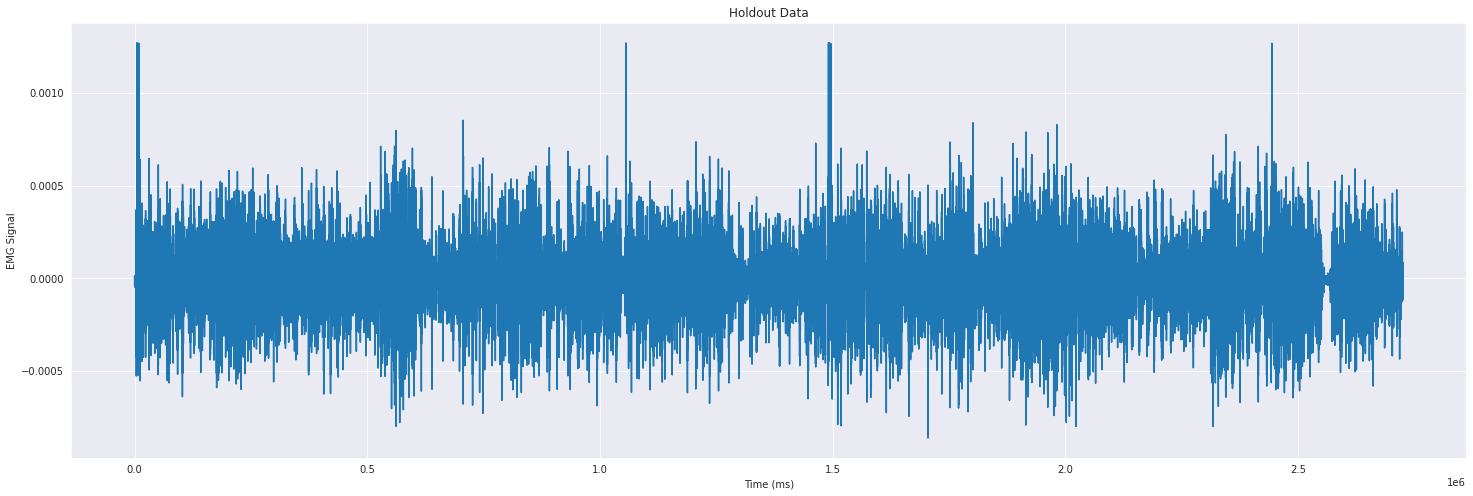

In [66]:
# Plot Holdout data
plt.figure(figsize=(25,8))
plt.plot(holdout_data[holdout_data['class'] == 0].iloc[:, 1:8].mean(axis=1))

# Add a legend and set the title and axis labels
plt.title('Holdout Data')
plt.xlabel('Time (ms)')
plt.ylabel('EMG Signal')
# Show the plot
plt.show()

### Labeled Data

In [35]:
labeled_data = all_data.loc[all_data['class'] != 0]
labeled_data = labeled_data.reset_index(drop=True)

In [36]:
labeled_data

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class,subject_id
0,2400,-0.00001,0.00000,-0.00001,0.00000,0.00000,-0.00001,-0.00001,0.00001,1.0,1
1,2401,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
2,2402,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
3,2403,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
4,2404,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1512745,50226,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6.0,36
1512746,50227,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6.0,36
1512747,50228,0.00009,0.00001,0.00003,0.00001,-0.00003,-0.00008,0.00004,0.00000,6.0,36
1512748,50229,0.00014,0.00003,-0.00001,0.00001,-0.00012,0.00006,-0.00007,-0.00013,6.0,36


#### Plot Labeled Data

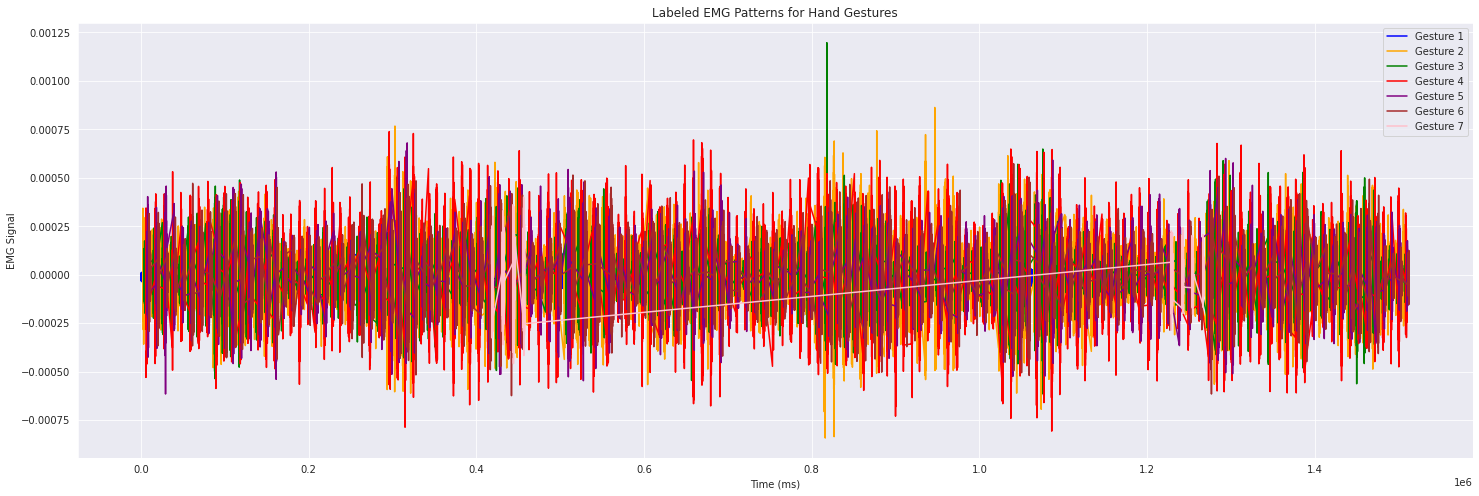

In [67]:
# Create a dictionary of gestures and their corresponding colors
gesture_colors = {1: 'blue', 2: 'orange', 3: 'green', 4: 'red', 5: 'purple', 6: 'brown', 7: 'pink'}

plt.figure(figsize=(25,8))
# Iterate through each gesture and plot it with a different color
for gesture in gesture_colors:
    gesture_data = labeled_data[labeled_data['class'] == gesture].iloc[:, 1:8].mean(axis=1)
    plt.plot(gesture_data, color=gesture_colors[gesture], label=f'Gesture {gesture}')

# Add a legend and set the title and axis labels
plt.title('Labeled EMG Patterns for Hand Gestures')
plt.xlabel('Time (ms)')
plt.ylabel('EMG Signal')
plt.legend()

# Show the plot
plt.show()

In [68]:
labeled_data['class'].unique()

array([1., 2., 3., 4., 5., 6., 7.])

In [69]:
labeled_data.isna().sum()

time          0
channel1      0
channel2      0
channel3      0
channel4      0
channel5      0
channel6      0
channel7      0
channel8      0
class         0
subject_id    0
dtype: int64

### Train Test Split

Now we will split the labeled data into a partition of train-validation-test split of 70%-10%-20%. We have over 1.5M data records as labeled so, our test set will contain 300K records. We shall also use stratified sampling based on class in all the datasets.

We shall be using the **train_test_split()** function available in **sklearn** library for this purpose.



In [70]:
features = labeled_data.drop('class', axis=1)
targets = labeled_data['class']
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=42, stratify=targets)
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.10, random_state=42, stratify=targets)

In [71]:
print('DATA SPLITS \n1. Train: {} \n2. Validation: {} \n3. Test: {}'.format(X_train.shape, X_val.shape, X_test.shape))

DATA SPLITS 
1. Train: (1361475, 10) 
2. Validation: (151275, 10) 
3. Test: (302550, 10)


In [72]:
X_train.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,subject_id
1095307,41546,0.00000,-0.00001,0.00004,0.00018,0.00026,0.00012,0.00005,-0.00001,26
889230,40309,-0.00018,0.00004,0.00017,0.00019,0.00061,0.00007,0.00017,0.00024,21
278884,34899,-0.00005,-0.00005,0.00001,0.00005,-0.00002,0.00002,0.00002,0.00002,7
730379,16604,-0.00003,-0.00007,-0.00022,-0.00045,0.00008,-0.00005,0.00002,0.00000,18
422986,43969,-0.00069,0.00003,0.00030,0.00088,0.00031,-0.00018,0.00057,0.00038,11


## Data Preprocessing

In [72]:
## Insert Visualization Code

In [72]:
## Insert Other Code

## Feature Engineering

In [116]:
def mean(X):
    return np.mean(X, axis=1)
def std(X):
    return np.std(X, axis=1)
def ptp(X):
    return np.ptp(X, axis=1)
def var(X):
    return np.var(X, axis=1)
def minim(X):
    return np.min(X, axis=1)
def maxim(X):
    return np.max(X, axis=1)
def argmin(X):
    return np.argmin(X, axis=1)
def argmax(X):
    return np.argmax(X, axis=1)
def rmse(X):
    return np.sqrt(np.mean(X**2, axis=1))
def abs_diff(X):
    return np.sum(np.abs(np.diff(X, axis=1)),axis=1)
def skewness(X):
    return stats.skew(X, axis=1)
def kurt(X):
    return stats.kurtosis(X, axis=1)
def entropy(X):
    hist, _ = np.histogram(X, bins=256, density=True)
    hist = hist[hist > 0]
    result = -np.sum(hist * np.log2(hist))
    return np.full(X.shape[0], result)
def hyper_dimension(X):
    n_samples, n_features = X.shape
    result = np.sqrt(n_samples) * (n_features / np.sqrt(n_samples - 1))
    return np.full(X.shape[0], result)
def dwt_coeffs(X, wavelet='db4'):
    coeffs = pywt.dwt(X, wavelet)
    cA, cD = coeffs
    return np.concatenate([cA.mean(axis=1), cD.mean(axis=1), cA.std(axis=1), cD.std(axis=1)])
def spectrogram(X):
    S = np.abs(librosa.stft(X))
    return np.mean(librosa.power_to_db(S**2), axis=1)
def mfcc(X, sr=22050, n_mfcc=20):
    mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)

def scalogram(X, wavelet='morl'):
    scales = np.arange(1, 129)
    coefs, freqs = pywt.cwt(X, scales, wavelet)
    return np.abs(coefs)
def fractal_dimension(X):
    return np.array([dfa(x) for x in X])
def lyapunov_exponent(X):
    return np.array([np.nan] * len(X))
def corr_dim(X):
    return np.array([nolds.corr_dim(X[i], emb_dim=4, rvals='default')[0] for i in range(X.shape[0])])

def concat_features(X):
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    features = [mean(X),
                std(X),
                ptp(X),
                var(X),
                rmse(X),
                abs_diff(X),
                skewness(X),
                kurt(X),
                entropy(X),
                ]
    return np.vstack(features)

                # minim(X),
                # maxim(X),
                # argmin(X),
                # argmax(X),
                # hyper_dimension(X),
                # dwt_coeffs(X),
                # mfcc(X),
                # scalogram(X, wavelet='morl'),
                # fractal_dimension(X),
                # lyapunov_exponent(X),
                # corr_dim(X),
                

In [119]:
X_train.shape

(1361475, 10)

In [120]:
X_train.head()

,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,subject_id
1095307,41546,0.00000,-0.00001,0.00004,0.00018,0.00026,0.00012,0.00005,-0.00001,26
889230,40309,-0.00018,0.00004,0.00017,0.00019,0.00061,0.00007,0.00017,0.00024,21
278884,34899,-0.00005,-0.00005,0.00001,0.00005,-0.00002,0.00002,0.00002,0.00002,7
730379,16604,-0.00003,-0.00007,-0.00022,-0.00045,0.00008,-0.00005,0.00002,0.00000,18
422986,43969,-0.00069,0.00003,0.00030,0.00088,0.00031,-0.00018,0.00057,0.00038,11


In [140]:
# Extract features for each channel
col_names = []
channel_features = []
for i in range(8):
    X = X_train[f"channel{i+1}"].values
    channel_features.append(concat_features(X).T)
print(len(channel_features))    

# Pad the shorter feature arrays with zeros
max_rows = max(len(arr) for arr in channel_features)
for i in range(8):
    num_rows = len(channel_features[i])
    if num_rows < max_rows:
        num_cols = channel_features[i].shape[1]
        padding = np.zeros((max_rows - num_rows, num_cols))
        channel_features[i] = np.concatenate([channel_features[i], padding], axis=0)
    col_names.append([f"channel{i}_{feat}" for feat in ["mean", "std", "ptp", "var", "rmse", "abs_diff", "skewness", "kurt", "entropy"]])
    

# Concatenate the features
ffe_data = np.concatenate(channel_features, axis=1)
all_chnls = [chnl for col in col_names for chnl in col]
ffe_df = pd.DataFrame(ffe_data, columns=all_chnls)

# Merge the feature dataframe with X_train
merged_df = pd.concat([X_train.reset_index(drop=True), ffe_df], axis=1)
print('Engineered Features: ', merged_df.shape)
merged_df.head()

<ipython-input-116-5db65aab0c04>:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(X, axis=1)
<ipython-input-116-5db65aab0c04>:24: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(X, axis=1)


8
Engineered Features:  (1361475, 82)


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,subject_id,channel0_mean,channel0_std,channel0_ptp,channel0_var,channel0_rmse,channel0_abs_diff,channel0_skewness,channel0_kurt,channel0_entropy,channel1_mean,channel1_std,channel1_ptp,channel1_var,channel1_rmse,channel1_abs_diff,channel1_skewness,channel1_kurt,channel1_entropy,channel2_mean,channel2_std,channel2_ptp,channel2_var,channel2_rmse,channel2_abs_diff,channel2_skewness,channel2_kurt,channel2_entropy,channel3_mean,channel3_std,channel3_ptp,channel3_var,channel3_rmse,channel3_abs_diff,channel3_skewness,channel3_kurt,channel3_entropy,channel4_mean,channel4_std,channel4_ptp,channel4_var,channel4_rmse,channel4_abs_diff,channel4_skewness,channel4_kurt,channel4_entropy,channel5_mean,channel5_std,channel5_ptp,channel5_var,channel5_rmse,channel5_abs_diff,channel5_skewness,channel5_kurt,channel5_entropy,channel6_mean,channel6_std,channel6_ptp,channel6_var,channel6_rmse,channel6_abs_diff,channel6_skewness,channel6_kurt,channel6_entropy,channel7_mean,channel7_std,channel7_ptp,channel7_var,channel7_rmse,channel7_abs_diff,channel7_skewness,channel7_kurt,channel7_entropy
0,41546,0.00000,-0.00001,0.00004,0.00018,0.00026,0.00012,0.00005,-0.00001,26,0.00000,0.0,0.0,0.0,0.00000,0.0,NaN,NaN,-1.100594e+06,-0.00001,0.0,0.0,0.0,0.00001,0.0,NaN,NaN,-1.146627e+06,0.00004,0.0,0.0,0.0,0.00004,0.0,NaN,NaN,-1.124805e+06,0.00018,0.0,0.0,0.0,0.00018,0.0,NaN,NaN,-1.035291e+06,0.00026,0.0,0.0,0.0,0.00026,0.0,NaN,NaN,-998506.797551,0.00012,0.0,0.0,0.0,0.00012,0.0,NaN,NaN,-1.035706e+06,0.00005,0.0,0.0,0.0,0.00005,0.0,NaN,NaN,-1.102190e+06,-0.00001,0.0,0.0,0.0,0.00001,0.0,NaN,NaN,-1.092464e+06
1,40309,-0.00018,0.00004,0.00017,0.00019,0.00061,0.00007,0.00017,0.00024,21,-0.00018,0.0,0.0,0.0,0.00018,0.0,NaN,NaN,-1.100594e+06,0.00004,0.0,0.0,0.0,0.00004,0.0,NaN,NaN,-1.146627e+06,0.00017,0.0,0.0,0.0,0.00017,0.0,NaN,NaN,-1.124805e+06,0.00019,0.0,0.0,0.0,0.00019,0.0,NaN,NaN,-1.035291e+06,0.00061,0.0,0.0,0.0,0.00061,0.0,NaN,NaN,-998506.797551,0.00007,0.0,0.0,0.0,0.00007,0.0,NaN,NaN,-1.035706e+06,0.00017,0.0,0.0,0.0,0.00017,0.0,NaN,NaN,-1.102190e+06,0.00024,0.0,0.0,0.0,0.00024,0.0,NaN,NaN,-1.092464e+06
2,34899,-0.00005,-0.00005,0.00001,0.00005,-0.00002,0.00002,0.00002,0.00002,7,-0.00005,0.0,0.0,0.0,0.00005,0.0,NaN,NaN,-1.100594e+06,-0.00005,0.0,0.0,0.0,0.00005,0.0,NaN,NaN,-1.146627e+06,0.00001,0.0,0.0,0.0,0.00001,0.0,NaN,NaN,-1.124805e+06,0.00005,0.0,0.0,0.0,0.00005,0.0,NaN,NaN,-1.035291e+06,-0.00002,0.0,0.0,0.0,0.00002,0.0,NaN,NaN,-998506.797551,0.00002,0.0,0.0,0.0,0.00002,0.0,NaN,NaN,-1.035706e+06,0.00002,0.0,0.0,0.0,0.00002,0.0,NaN,NaN,-1.102190e+06,0.00002,0.0,0.0,0.0,0.00002,0.0,NaN,NaN,-1.092464e+06
3,16604,-0.00003,-0.00007,-0.00022,-0.00045,0.00008,-0.00005,0.00002,0.00000,18,-0.00003,0.0,0.0,0.0,0.00003,0.0,NaN,NaN,-1.100594e+06,-0.00007,0.0,0.0,0.0,0.00007,0.0,NaN,NaN,-1.146627e+06,-0.00022,0.0,0.0,0.0,0.00022,0.0,NaN,NaN,-1.124805e+06,-0.00045,0.0,0.0,0.0,0.00045,0.0,NaN,NaN,-1.035291e+06,0.00008,0.0,0.0,0.0,0.00008,0.0,NaN,NaN,-998506.797551,-0.00005,0.0,0.0,0.0,0.00005,0.0,NaN,NaN,-1.035706e+06,0.00002,0.0,0.0,0.0,0.00002,0.0,NaN,NaN,-1.102190e+06,0.00000,0.0,0.0,0.0,0.00000,0.0,NaN,NaN,-1.092464e+06
4,43969,-0.00069,0.00003,0.00030,0.00088,0.00031,-0.00018,0.00057,0.00038,11,-0.00069,0.0,0.0,0.0,0.00069,0.0,NaN,NaN,-1.100594e+06,0.00003,0.0,0.0,0.0,0.00003,0.0,NaN,NaN,-1.146627e+06,0.00030,0.0,0.0,0.0,0.00030,0.0,NaN,NaN,-1.124805e+06,0.00088,0.0,0.0,0.0,0.00088,0.0,NaN,NaN,-1.035291e+06,0.00031,0.0,0.0,0.0,0.00031,0.0,NaN,NaN,-998506.797551,-0.00018,0.0,0.0,0.0,0.00018,0.0,NaN,NaN,-1.035706e+06,0.00057,0.0,0.0,0.0,0.00057,0.0,NaN,NaN,-1.102190e+06,0.00038,0.0,0.0,0.0,0.00038,0.0,NaN,NaN,-1.092464e+06


In [143]:
merged_df.to_csv('all_ext_features_data.csv', index=False)